<h1 align="center">GA for the Running-Dinner problem DEMO</h1> 

# Table of Contents
- [1. Introduction](#intro)
- [2. Setup & Imports](#setup)
- [3. Running Dinner Problem Configs](#configs)
- [4. Fitness](#fitness)
   - [4.1. Effect of alpha and beta on fitness](#fitnessalpha)
- [5. Genome](#genome)
- [6. Mutation Demonstrations](#mutations)
   - [6.1. Logistic Mutation](#logisticm)
   - [6.2. Logistic Mutation 2 (Pacman Mutation)](#pacman)
   - [6.3. Social Mutation](#socialm)
- [7. Crossover Demonstratins](#crossovers)
   - [7.1. Full Crossover](#full)
   - [7.2. Logistic Crossover](#logistic)
- [8. Selection Demonstratins](#selections)
   - [8.1. Selection Pressure vs. Average Winner Fitness](#selectionpressure)

----

# 1. Introduction <a class="anchor" id="intro"></a>

----

This notebook showcases the key classes and functions that power our GA:

- **Genome**: Defines how a candidate solution looks like at the genome level. It encodes host assignments (house_assignments) and rotation of guests (course_assignments).  
- **ResourceFitness(data_matrix)**: defines how good any given Genome is, given the distance matrix and weights ($\alpha$ and $\beta$). It computes social score and logistic score and fitness function is defined as: $\alpha s_s + \beta s_l$.
- **Mutation Functions**: 
  - logistic_mutation  
  - logistic_mutation_2
  - social_mutation    
- **Crossover Functions**:  
  - full_crossover  
  - logistic_crossover    
- **Selection Algorithms**:  
  - tournament_selection  
  - rank_selection  
- **SolutionRD**: Wraps a Genome, a ResourceFitness instance, and then offers .mutation(), .crossover(), and a .fitness property to drive the evolutionary loop.
- **config.py** defines the problem's hard parameters

----

# 2. Setup & Imports <a class="anchor" id="setup"></a>
Import packages & data

----

In [1]:
import os, sys, random, numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from pathlib import Path
sys.path.append(os.path.abspath("."))

# Genetic Algorithm 
import Genetic_algorithm.config as config
from Genetic_algorithm.genome import Genome
from Genetic_algorithm.fitness import ResourceFitness
from Genetic_algorithm.mutations import social_mutation, logistic_mutation, logistic_mutation_2
from Genetic_algorithm.crossovers import social_crossover, logistic_crossover_2, full_crossover
from Genetic_algorithm.selection_algorithms import tournament_selection, rank_selection
from Genetic_algorithm.solution_rd import SolutionRD

random.seed(0)
np.random.seed(0)

Now, let's import the **official** travel-time matrix:

```text
data/distance_matrix_official.csv   →   pandas DataFrame   →   NumPy array

In [2]:
# Path to the CSV
csv_path = Path("data/distance_matrix_official.csv")
assert csv_path.exists(), f"CSV not found: {csv_path}"

# Number of participants
n = config.N_PARTICIPANTS

# We assume the CSV has a leading index‐column plus N data columns, and at least N+1 rows total.
usecols = [0] + list(range(1, n+1))  # keep the index-col plus the first n data cols
df = pd.read_csv(
    csv_path,
    index_col=0,
    usecols=usecols,
    nrows=n
)

# Convert to NumPy array
distance_matrix = df.to_numpy()
assert distance_matrix.shape == (n, n), (
    f"Expected ({n},{n}), got {distance_matrix.shape}"
)

print("Loaded distance matrix shape:", distance_matrix.shape)

Loaded distance matrix shape: (10, 10)


----

# 3. Running Dinner Problem Configs <a class="anchor" id="configs"></a>
`config.py` keeps all hard-coded parameters

----

In [3]:
attrs = ["N_PARTICIPANTS", "N_COURSES", "N_HOUSES",
         "HOUSE_CAPACITY", "LEN_COURSE"]
for a in attrs:
    print(f"{a:16} → {getattr(config, a)}")

N_PARTICIPANTS   → 10
N_COURSES        → 3
N_HOUSES         → 7
HOUSE_CAPACITY   → 6
LEN_COURSE       → 12


----

# 4. Fitness <a class="anchor" id="fitness"></a>
fitness.py defines a class that implements the fitness function for a Running Dinner solution.

----

## Class: ResourceFitness

- **Role & Responsibility:**  
  - Stores the **distance matrix** (participant-to-participant travel times) plus two weights, **α** (social) and **β** (logistic).  
  - Defines an .evaluate(genome) → float method that:  
    1. Computes a **social score**: number of unique meetings/N_PARTICIPANTS. We want to maximize the average number of unique people met per participant.  
    2. Computes a **logistic score**: max distance/actual distance. We want to maximize the logistic score by minimizing the actual distance traveled by participants.  
    3. Combines them as:  
       $
         \text{fitness} = \alpha s_s \;+\; \beta s_l
       $

- **Instances of ResourceFitness:**  
  - Are passed to each SolutionRD so that an individual can lazily compute and cache its .fitness by calling into this evaluator.

Let's check if we can generate a population of SolutionRD, print their fitness, and their genome:

In [4]:
my_fitness = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
first_solution = SolutionRD(my_fitness, Genome, [logistic_mutation, social_mutation], [logistic_crossover_2, social_crossover])

# Generate population of size n individuals
population = []
for _ in range(10):
    ind = SolutionRD(
        fitness_instance = my_fitness,
        genome_class     = Genome,
        mutation_functions   = [social_mutation, logistic_mutation],
        crossover_functions  = [social_crossover, logistic_crossover_2],
    )
    population.append(ind)
# Calculate fitness for each individual
fitness_values = [ind.fitness for ind in population]
# Sort individuals by fitness
sorted_population = sorted(population, key=lambda x: x.fitness)

# display sorted individuals fitness and genome
for i, ind in enumerate(sorted_population):
    print(f"Individual {i}: Fitness = {ind.fitness}, Genome = {ind.genome.encode()}")

Individual 0: Fitness = 1.8783934432473954, Genome = [ 0 -1  0  2  2  1  1  0  3  9  8  4  6  2  1  5  7 -1 -1  5  0  1  2  7
  9  6  3  8  4 -1 -1  3  2  8  5  9  7  4  0  1  6 -1 -1]
Individual 1: Fitness = 2.091590473658014, Genome = [-1  0  2  2  0  1  1  1  6  8  2  0  9  4  5  3  7 -1 -1  5  1  8  3  2
  7  6  4  0  9 -1 -1  2  6  4  1  8  0  3  7  5  9 -1 -1]
Individual 2: Fitness = 2.2880223307185665, Genome = [ 2  1  0  0  1 -1  2  2  6  8  0  9  1  3  7  5  4 -1 -1  1  0  7  2  6
  8  4  9  5  3 -1 -1  0  5  1  3  7  9  6  2  8  4 -1 -1]
Individual 3: Fitness = 2.369498000406152, Genome = [ 1  2  2  0 -1  0  1  3  2  4  7  6  9  5  8  0  1 -1 -1  0  8  7  2  3
  5  6  4  9  1 -1 -1  1  6  7  8  3  4  2  0  9  5 -1 -1]
Individual 4: Fitness = 2.4081476342033725, Genome = [ 1  2  0 -1  2  1  0  7  2  0  5  8  3  1  9 -1  4  6 -1  1  9  6  4  0
 -1  8  5 -1  2  7  3  3  0  1  5  8  2 -1 -1  6  7  4  9]
Individual 5: Fitness = 2.5006660303117583, Genome = [-1  2  2  0  1  0  1  7

Now let's plot the social score, logistic score, and fitness of our individuals:

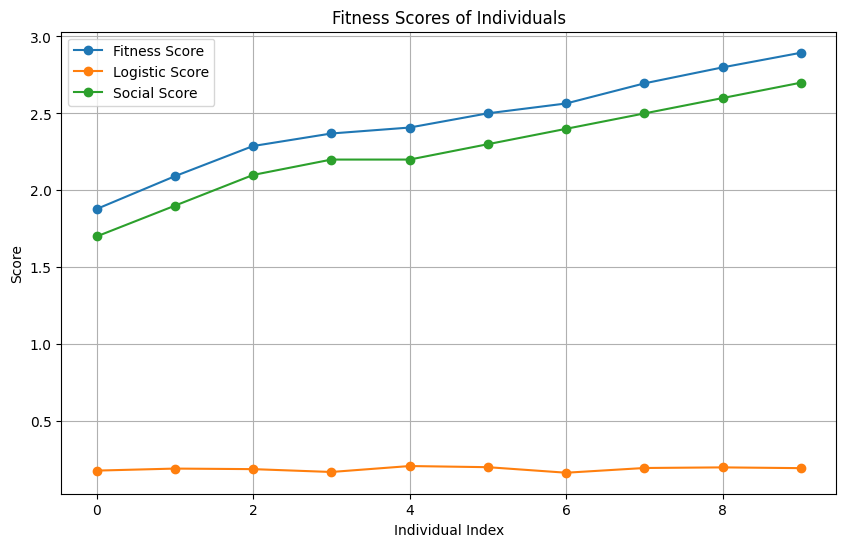

In [5]:
# Plot fitness score, logistic score and social score
def plot_fitness_scores(individuals):
    fitness_scores = [ind.fitness for ind in individuals]
    logistic_scores = [ind.fitness_instance._calculate_logistic_fitness(ind.genome) for ind in individuals]
    social_scores = [ind.fitness_instance._calculate_social_fitness(ind.genome) for ind in individuals]

    plt.figure(figsize=(10, 6))
    plt.plot(fitness_scores, label='Fitness Score', marker='o')
    plt.plot(logistic_scores, label='Logistic Score', marker='o')
    plt.plot(social_scores, label='Social Score', marker='o')
    plt.xlabel('Individual Index')
    plt.ylabel('Score')
    plt.title('Fitness Scores of Individuals')
    plt.legend()
    plt.grid()
    plt.show()
# Plot the fitness scores of the sorted population
plot_fitness_scores(sorted_population)

----

### 4.1. Effect of alpha and beta on fitness: <a class="anchor" id="fitnessalpha"></a>
How does decreasing $\alpha$ value affect the fitness score.

---

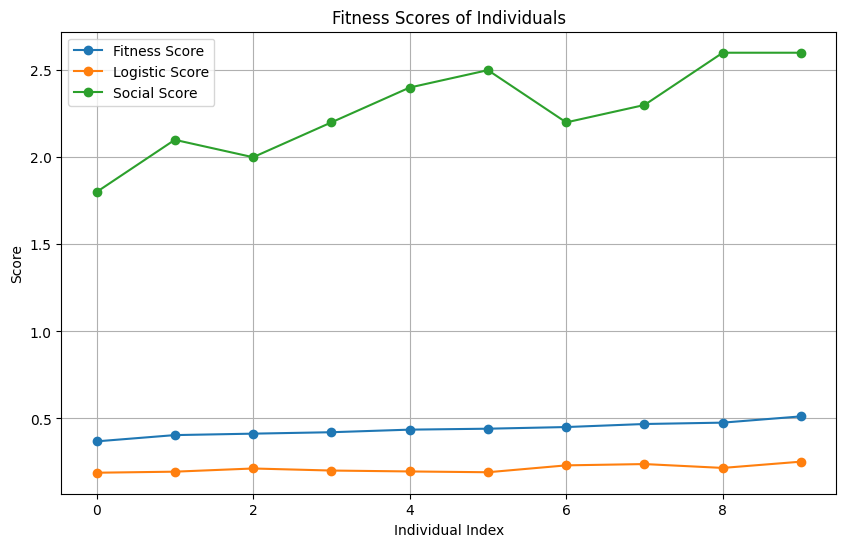

In [6]:
my_fitness1 = ResourceFitness(distance_matrix, alpha=0.1, beta=1.0)
# Generate population of size n individuals
population = []
for _ in range(10):
    ind = SolutionRD(
        fitness_instance = my_fitness1,
        genome_class     = Genome,
        mutation_functions   = [social_mutation, logistic_mutation],
        crossover_functions  = [social_crossover, logistic_crossover_2],
    )
    population.append(ind)
# Calculate fitness for each individual
fitness_values = [ind.fitness for ind in population]
# Sort individuals by fitness
sorted_population = sorted(population, key=lambda x: x.fitness)

plot_fitness_scores(sorted_population)

----

# 5. Genome <a class="anchor" id="genome"></a>
genome.py defines a class that models the genotype of a Running Dinner solution.

----

## Class: Genome

- **Role & Responsibility:**  
  - Holds two core arrays:  
    1. **house_assignments** (int[N_HOUSES]): which course each house hosts (or -1 if unused).  
    2. **course_assignments** (int[N_COURSES × LEN_COURSE]): which participants sit at each “seat” in each course.  
  - Provides methods to **encode** these arrays into a 1-D chromosome, **decode** back, and query slices (e.g. “which seats belong to course _𝑐_”).  
  - Encapsulates all low-level bit twiddling needed to shuffle, swap, or fix the subblocks when applying genetic operators.  

- **Instances of Genome:**  
  - Are concrete **genotypes** (i.e. a specific assignment of hosts & guests).  
  - Get passed into SolutionRD objects and get mutated, crossed over, and ultimately evaluated.

SolutionRD's genome is composed of two blocks: house_assignments and course_assignments.

* **house assignments**: An array of length N_HOUSES in which the entry at index i denotes the course (0=starter, 1=main, 2=dessert, or –1 for an unused house) served at house i. 

* **course assignments**: An array of length N_COURSES × LEN_COURSE, i.e., N_COURSES consecutive blocks each of size LEN_COURSE. Each entry in that block is a participant index (0 to N_PARTICIPANTS–1), or -1 if that “seat” in the course is unused. The array is in the following order: Participants at the houses hosting appetizers, participant list at the houses hosting main course, and finally participants of the houses hosting desserts.

In [7]:
fitness = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)

ind = SolutionRD(
    fitness_instance = fitness,
    genome_class     = Genome,
    mutation_functions   = [social_mutation, logistic_mutation],
    crossover_functions  = [social_crossover, logistic_crossover_2],
)
# Access the individual's fitness (lazy evaluation is triggered by the property)
print("Encoded genome sample:\n", ind.genome.encode())
print("Decoded genome sample:\n", ind.genome.decode())
print("Individual's house assignments:\n", ind.genome.house_assignments)
print("Individual's course assignments:\n", ind.genome.course_assignments)
print("Individual's fitness:", ind.fitness)

Encoded genome sample:
 [ 2  0  0 -1  1  2  1  8  7  6  0  9  1  5  4 -1  3 -1  2  0  4  5  8  9
  3 -1  6 -1  2  7  1  7  0  2  4  8  3  1  5  6 -1  9 -1]
Decoded genome sample:
 (array([ 2,  0,  0, -1,  1,  2,  1]), array([ 8,  7,  6,  0,  9,  1,  5,  4, -1,  3, -1,  2,  0,  4,  5,  8,  9,
        3, -1,  6, -1,  2,  7,  1,  7,  0,  2,  4,  8,  3,  1,  5,  6, -1,
        9, -1]))
Individual's house assignments:
 [ 2  0  0 -1  1  2  1]
Individual's course assignments:
 [ 8  7  6  0  9  1  5  4 -1  3 -1  2  0  4  5  8  9  3 -1  6 -1  2  7  1
  7  0  2  4  8  3  1  5  6 -1  9 -1]
Individual's fitness: 2.539046536093758


The distance matrix below represents the distances between running dinner participants and their homes (if they are hosts). It is used in ResourceFitness to calculate logistic score.

In [8]:
print("Loaded distance matrix shape:", distance_matrix.shape)
print("Distance matrix:\n", pd.DataFrame(distance_matrix))
# Set the display format for floats
# Display float with 1 decimal place
pd.options.display.float_format = '{:0.1f}'.format

Loaded distance matrix shape: (10, 10)
Distance matrix:
        0      1       2       3       4       5       6       7       8  \
0  0.001  9.700  50.900  22.800  15.800  56.200  54.000   7.800  18.100   
1    NaN  0.001  43.900  15.800  10.500  49.200  47.100   3.500  11.000   
2    NaN    NaN   0.001  13.900  17.000   5.300   3.100  19.900   7.600   
3    NaN    NaN     NaN   0.001  45.000  33.300  31.200  47.900  35.600   
4    NaN    NaN     NaN     NaN   0.001  51.500  49.400  14.800  16.500   
5    NaN    NaN     NaN     NaN     NaN   0.001  44.400  14.600  11.500   
6    NaN    NaN     NaN     NaN     NaN     NaN   0.001  16.800   4.400   
7    NaN    NaN     NaN     NaN     NaN     NaN     NaN   0.001  13.100   
8    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN   0.001   
9    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

        9  
0  18.300  
1   7.900  
2  10.500  
3  38.600  
4  18.800  
5  13.800  
6   7.400  
7  10.200  
8   6.300

----

# 6. Mutation Demonstrations <a class="anchor" id="mutations"></a>
Below we show each mutation in isolation. We apply each operator to an individual to see “before → after.”

---

----

### 6.1. Logistic Mutation <a class="anchor" id="logisticm"></a>
How does it work:
1) Pick two house ids at random, where id_i!=id_2
2) Swap courses assigned to house with id_1 and id_2
3) Fix course assignments (make sure hosts are back in their houses)

---

In [9]:
np.random.seed(0)
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
base_ind = SolutionRD(fitness, Genome,
                      mutation_functions=[logistic_mutation, logistic_mutation],
                      crossover_functions=[])

# deep copy the base individual
mutant1 = copy.deepcopy(base_ind)

In [10]:
# apply logistic_mutation_2
mutant1.mutation()

# display base_ind genome
print("Base individual genome:\n", base_ind.genome.encode())
print("Mutant individual genome:\n", mutant1.genome.encode())

print("Base individual house assignments:\n", base_ind.genome.house_assignments)
print("Mutant individual house assignments:\n", mutant1.genome.house_assignments)
 
print("Base individual course assignments:\n", base_ind.genome.course_assignments) 
print("Mutant individual course assignments:\n", mutant1.genome.course_assignments)

print("Base individual fitness:", base_ind.fitness)
print("Mutant individual fitness:", mutant1.fitness)

Base individual genome:
 [-1  1  0  1  0  2  2  3  2  1 -1  9  8  0  6  7  4 -1  5  1  9 -1  0 -1
  2  4  8  3  7  5  6  7  8  3  4  5 -1 -1  9  6  2  0  1]
Mutant individual genome:
 [ 0  1  0  1 -1  2  2  3 -1  1  0  9  8  2  6  7  4 -1  5  1  9 -1  0 -1
  2  4  8  3  7  5  6  7  8  3  4  5 -1 -1  9  6  2  0  1]
Base individual house assignments:
 [-1  1  0  1  0  2  2]
Mutant individual house assignments:
 [ 0  1  0  1 -1  2  2]
Base individual course assignments:
 [ 3  2  1 -1  9  8  0  6  7  4 -1  5  1  9 -1  0 -1  2  4  8  3  7  5  6
  7  8  3  4  5 -1 -1  9  6  2  0  1]
Mutant individual course assignments:
 [ 3 -1  1  0  9  8  2  6  7  4 -1  5  1  9 -1  0 -1  2  4  8  3  7  5  6
  7  8  3  4  5 -1 -1  9  6  2  0  1]
Base individual fitness: 2.678695964608448
Mutant individual fitness: 2.749962194330039


----

### 6.2 Logistic Mutation 2 (pacman mutation) <a class="anchor" id="pacman"></a>
How does it work:
1) Pick a window size at random from range len(house_assignments)
2) Concatenate house assignments array accoridng to window size drawed in 1)
3) Fix course assignments (because some hosts might have been moved out of their houses)

---

In [11]:
np.random.seed(0)
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
base_ind = SolutionRD(fitness, Genome,
                      mutation_functions=[logistic_mutation_2, logistic_mutation_2],
                      crossover_functions=[])

# deep copy the base individual
mutant2 = copy.deepcopy(base_ind)

In [12]:
# apply logistic_mutation
mutant2.mutation()

# display base_ind genome
print("Base individual genome:\n", base_ind.genome.encode())
print("Mutant individual genome:\n", mutant2.genome.encode())

print("Base individual house assignments:\n", base_ind.genome.house_assignments)
print("Mutant individual house assignments:\n", mutant2.genome.house_assignments)

print("Base individual course assignments:\n", base_ind.genome.course_assignments)
print("Mutant individual course assignments:\n", mutant2.genome.course_assignments)

print("Base individual fitness:", base_ind.fitness)
print("Mutant individual fitness:", mutant2.fitness)

Base individual genome:
 [-1  1  0  1  0  2  2  3  2  1 -1  9  8  0  6  7  4 -1  5  1  8  9  0 -1
  2  4  5  3  7 -1  6  7  8  3  4  5 -1 -1  9  6  2  0  1]
Mutant individual genome:
 [ 2 -1  1  0  1  0  2  3  2  1 -1  9  8  0  6  7  4 -1  5  1  8  9  0 -1
  2  4  5  3  7 -1  6  7  8  3  4  5  0 -1  9  6  2 -1  1]
Base individual house assignments:
 [-1  1  0  1  0  2  2]
Mutant individual house assignments:
 [ 2 -1  1  0  1  0  2]
Base individual course assignments:
 [ 3  2  1 -1  9  8  0  6  7  4 -1  5  1  8  9  0 -1  2  4  5  3  7 -1  6
  7  8  3  4  5 -1 -1  9  6  2  0  1]
Mutant individual course assignments:
 [ 3  2  1 -1  9  8  0  6  7  4 -1  5  1  8  9  0 -1  2  4  5  3  7 -1  6
  7  8  3  4  5  0 -1  9  6  2 -1  1]
Base individual fitness: 2.770405962389403
Mutant individual fitness: 3.0091287295243623


----

### 6.3 Social Mutation <a class="anchor" id="socialm"></a>
How does it work:
1) Pick a participant's "seat" at random
2) Pick another seat at random in a different house hosting the same course
3) Pick course at random
4) Swap the two seats between two houses (hosting the same meal)
5) Fix course assignments in case the hosts have been displaced

---

In [13]:
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
base_ind = SolutionRD(fitness, Genome,
                      mutation_functions=[social_mutation, social_mutation],
                      crossover_functions=[])

# deep copy the base individual
mutant3 = copy.deepcopy(base_ind)

In [14]:
# apply social_mutation
mutant3.mutation()

# display base_ind genome
print("Base individual genome:\n", base_ind.genome.encode())
print("Mutant individual genome:\n", mutant3.genome.encode())

print("Base individual house assignments:\n", base_ind.genome.house_assignments)
print("Mutant individual house assignments:\n", mutant3.genome.house_assignments)

print("Base individual course assignments:\n", base_ind.genome.course_assignments)
print("Mutant individual course assignments:\n", mutant3.genome.course_assignments)

print("Base individual fitness:", base_ind.fitness)
print("Mutant individual fitness:", mutant3.fitness)

Base individual genome:
 [ 2  1 -1  2  0  0  1  4  0  8  1  3  6  5  9  2  7 -1 -1  1  3  0  4  8
  2  6  9  7  5 -1 -1  0  1  5  4  7  8  3  2  9  6 -1 -1]
Mutant individual genome:
 [ 2  1 -1  2  0  0  1  4  0  8  1  3  6  5  9  2  7 -1 -1  1  3  5  4  8
  2  6  9  7  0 -1 -1  0  1  5  4  7  8  3  2  9  6 -1 -1]
Base individual house assignments:
 [ 2  1 -1  2  0  0  1]
Mutant individual house assignments:
 [ 2  1 -1  2  0  0  1]
Base individual course assignments:
 [ 4  0  8  1  3  6  5  9  2  7 -1 -1  1  3  0  4  8  2  6  9  7  5 -1 -1
  0  1  5  4  7  8  3  2  9  6 -1 -1]
Mutant individual course assignments:
 [ 4  0  8  1  3  6  5  9  2  7 -1 -1  1  3  5  4  8  2  6  9  7  0 -1 -1
  0  1  5  4  7  8  3  2  9  6 -1 -1]
Base individual fitness: 2.1422406832164276
Mutant individual fitness: 1.927929625714139


----

# 7. Crossover Demonstratins <a class="anchor" id="crossovers"></a>
Below we show each crossover in isolation. We apply each operator to an individual to see “before → after.”

---

----

### 7.1. Full Crossover <a class="anchor" id="full"></a>
1) Child1 takes on course assignment from Parent1 and house assignmnet from Parent 2, then fix_course_assignment to have valid genome
2) Child2 takes on course assignment from Parent2 and house assignmnet from Parent 1, then fix_course_assignment to have valid genome

---

In [15]:
np.random.seed(0)
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
parent1 = SolutionRD(fitness, Genome, [], [full_crossover, full_crossover])
parent2 = SolutionRD(fitness, Genome, [], [full_crossover, full_crossover])

print("Parent1 house assignments:\n", parent1.genome.house_assignments)
print("Parent2 house assignments:\n", parent2.genome.house_assignments)
print("Parent1 course assignments:\n", parent1.genome.course_assignments)
print("Parent2 course assignments:\n", parent2.genome.course_assignments)
print("Parent1 fitness:", parent1.fitness)
print("Parent2 fitness:", parent2.fitness)

Parent1 house assignments:
 [-1  1  0  1  0  2  2]
Parent2 house assignments:
 [ 2  1 -1  2  0  0  1]
Parent1 course assignments:
 [ 2  6  3  7  5  9  4  1  8  0 -1 -1  1  5  6  8  9  2  3  7  4  0 -1 -1
  5  2  7  4  8  9  6  1  0  3 -1 -1]
Parent2 course assignments:
 [ 1  9  4 -1  2  8  6  3  7  5 -1  0  1  5  3  9  4 -1  6  7  8  2  0 -1
  0  6  4 -1  9  7  3  2  5  8  1 -1]
Parent1 fitness: 1.9031565172755338
Parent2 fitness: 2.695048137324995


In [16]:
# apply crossover
child1, child2 = parent1.crossover(parent2)

# Display the child1 and child2 genomes after full crossover
print("Child1 house assignments:\n", child1.genome.house_assignments)
print("Child2 house assignments:\n", child2.genome.house_assignments)
print("Child1 course assignments:\n", child1.genome.course_assignments)
print("Child2 course assignments:\n", child2.genome.course_assignments)
print("Child1 fitness:", child1.fitness)
print("Child2 fitness:", child2.fitness)

Child1 house assignments:
 [ 2  1 -1  2  0  0  1]
Child2 house assignments:
 [-1  1  0  1  0  2  2]
Child1 course assignments:
 [ 2  6  3  7  4  9 -1  1  8  0  5 -1  1  5 -1  8  9  2  3  7  4  0  6 -1
  5  2  7  0  8  9  6  1  4  3 -1 -1]
Child2 course assignments:
 [ 2  7  3  9  6  1  4  0  8  5 -1 -1  1  0  8  9  5  7  3  4  6  2 -1 -1
  5  9  7  8  2  3  6  0  4  1 -1 -1]
Child1 fitness: 1.8815437029316184
Child2 fitness: 2.9995261549676804


----

### 7.2. Logistic Crossover <a class="anchor" id="logistic"></a>
How does it work:
1) Take house assignments arrays of two parents
2) Apply pillar crossover: Go by house id in house asignments arrays. Mask the houses which serve the same course in both parents' house assignments
3) Shuffle the house assignment where courses served were different between two parents
4) Fix course assignments

---

In [17]:
np.random.seed(0)
# build demo individual 
fitness  = ResourceFitness(distance_matrix, alpha=1.0, beta=1.0)
parent1 = SolutionRD(fitness, Genome, [], [logistic_crossover_2, logistic_crossover_2])
parent2 = SolutionRD(fitness, Genome, [], [logistic_crossover_2, logistic_crossover_2])

print("Parent1 house assignments:\n", parent1.genome.house_assignments)
print("Parent2 house assignments:\n", parent2.genome.house_assignments)
print("Parent1 course assignments:\n", parent1.genome.course_assignments)
print("Parent2 course assignments:\n", parent2.genome.course_assignments)
print("Parent1 fitness:", parent1.fitness)
print("Parent2 fitness:", parent2.fitness)

Parent1 house assignments:
 [-1  1  0  1  0  2  2]
Parent2 house assignments:
 [ 2  1 -1  2  0  0  1]
Parent1 course assignments:
 [ 3  2  1 -1  9  8  0  6  7  4 -1  5  1 -1  9  0 -1  2  4  8  3  7  5  6
  7  8  3  4  5 -1 -1  9  6  2  0  1]
Parent2 course assignments:
 [ 4  7  2  0  8  3  5  1  9  6 -1 -1  1  5  8  4  7  2  6  3  9  0 -1 -1
  0  2  7  5  4  9  3  8  1  6 -1 -1]
Parent1 fitness: 2.678695964608448
Parent2 fitness: 2.614694474227749


In [18]:
# Apply logistcic crossover
child5, child6 = parent1.crossover(parent2)

# display child5 and child 6 genomes after logistic crossover
print("Child5 house assignments:\n", child5.genome.house_assignments)
print("Child6 house assignments:\n", child6.genome.house_assignments)
print("Child5 course assignments:\n", child5.genome.course_assignments)
print("Child6 course assignments:\n", child6.genome.course_assignments)
print("Child5 fitness:", child5.fitness)
print("Child6 fitness:", child6.fitness)

Child5 house assignments:
 [ 2  1  0  1  0 -1  2]
Child6 house assignments:
 [ 0  1  2  2  0 -1  1]
Child5 course assignments:
 [ 3  2  1 -1  9  8  0  6  7  4 -1  5  1 -1  9  0 -1  2  4  8  3  7  5  6
  7  8  3  4  5  0 -1  9  6  2 -1  1]
Child6 course assignments:
 [-1  7  2  0  8  3  5  1  9  6  4 -1  1  5  8  4  7  2  6  3  9  0 -1 -1
  0  2  7  5  4  9  3  8  1  6 -1 -1]
Child5 fitness: 2.9975159383412877
Child6 fitness: 2.6181106905286144


----

# 8. Selection Demonstration  <a class="anchor" id="selections"></a>
We create a population of `SolutionRD` individuals and then pick the survivors using:

- **Tournament Selection** (k‐way): randomly sample \(k\) individuals and choose the one with the best fitness.  
- **Rank Selection**: sort individuals by fitness (highest→lowest), assign selection probabilities proportionally to rank, and draw one.

Both return the `SolutionRD` instance.

----

In [21]:
random.seed(0)
# Generate a population of 10 individuals
pop = [
    SolutionRD(
        fitness_instance   = fitness,
        genome_class       = Genome,
        mutation_functions = [social_mutation, logistic_mutation],
        crossover_functions= [social_crossover, logistic_crossover_2]
    )
    for _ in range(10)
]

# sort the population by fitness
pop.sort(key=lambda x: x.fitness)
# Tournament selection (k=3), picks the individual with highest fitness among 3 random draws
winner_tournament = tournament_selection(pop, k=3)

# Rank selection, assigns probabilities by descending fitness rank and selects one
winner_rank  = rank_selection(pop)

# Report
print("Starting population fitnesses:")
for i, ind in enumerate(pop):
    print(f"  {i:2}: {ind.fitness:.2f}")
print("Tournament winner fitness:", winner_tournament.fitness)
print("Rank-selection winner fitness:", winner_rank.fitness)

Starting population fitnesses:
   0: 1.95
   1: 2.01
   2: 2.13
   3: 2.31
   4: 2.34
   5: 2.41
   6: 2.49
   7: 2.51
   8: 2.65
   9: 2.82
Tournament winner fitness: 2.6504820963241826
Rank-selection winner fitness: 2.8195306783055254


----

### 8.1. Selection Pressure vs. Average Winner Fitness <a class="anchor" id="selectionpressure"></a>
We will visualize:

**Tournament Selection**: influence of tournament size `k` (with fixed population size). 

---

In [22]:
data_matrix_df = pd.read_csv('data/distance_matrix_official.csv', index_col=0)
data_matrix_np = data_matrix_df.to_numpy()

# a helper function to generate population of different sizes
def gen_pop(pop_size, genome_class, fitness_instance, mutation_functions, crossover_functions):
    return [
        SolutionRD(
            fitness_instance   = fitness_instance,
            genome_class       = genome_class,
            mutation_functions = mutation_functions,
            crossover_functions= crossover_functions
        )
        for _ in range(pop_size)
    ]

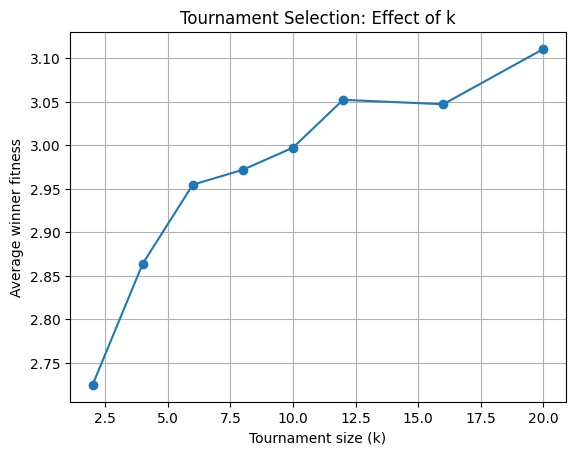

In [23]:
# Tournament-selection: vary k, fix pop_size
pop_size = 20
k_values = [2, 4, 6, 8, 10, 12, 16, 20]
avg_fitness_tourn = []
for k in k_values:
    favgs = []
    for _ in range(100):
        pop = gen_pop(pop_size, Genome, fitness, [social_mutation, logistic_mutation], [social_crossover, logistic_crossover_2])
        winner = tournament_selection(pop, k=k)
        favgs.append(winner.fitness)
    avg_fitness_tourn.append(np.mean(favgs))

# Plot tournament results
plt.figure()
plt.plot(k_values, avg_fitness_tourn, marker='o')
plt.xlabel("Tournament size (k)")
plt.ylabel("Average winner fitness")
plt.title("Tournament Selection: Effect of k")
plt.grid(True)
plt.show()

In the next notebooks we will:

* wrap the above in an evolutionary loop,
* grid-search parameters (see *3. Grid_search.ipynb*)
* perform an analysis of the best performing parameter configurations (see *4. Statistical_analysis.ipynb*)
* generate a final solution (see *5. Final_solution.ipynb*)